In [1]:
import os
os.chdir('../')
%pwd

'c:\\Users\\jacob\\Desktop\\Technica_Assesment\\Question_2\\Mushroom_Classification'

In [2]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path

In [3]:
from Mushroom_Classification_src.constants import *
from Mushroom_Classification_src.utils.common import read_yaml, create_directories

In [4]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
        )

        return data_transformation_config

In [5]:
import os
from Mushroom_Classification_src import logger
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os


class DataTransformation:
    def __init__(self, config: DataTransformationConfig,test_size=0.3, random_state=42, pca_components=2):
        self.config = config
        self.test_size = test_size
        self.random_state = random_state
        self.pca_components = pca_components


    def load_data(self):
        """Load data from the specified path."""
        data = pd.read_csv(self.config.data_path)
        logger.info("Loaded data with shape: %s", data.shape)
        return data

    def encode_features(self, features, target):
        """Apply Label Encoding to features and target."""
        encoder_features = LabelEncoder()
        for col in features.columns:
            features[col] = encoder_features.fit_transform(features[col])
        
        encoder_target = LabelEncoder()
        target = encoder_target.fit_transform(target)
        logger.info("Features and target encoded.")
        return features, target

    def scale_features(self, features_train, features_test):
        """Scale features using StandardScaler."""
        scaler = StandardScaler()
        scaler.fit(features_train)
        features_train_transformed = scaler.transform(features_train)
        features_test_transformed = scaler.transform(features_test)
        logger.info("Features scaled.")
        return features_train_transformed, features_test_transformed

    def apply_pca(self, features_train_transformed, features_test_transformed):
        """Apply PCA transformation to the data."""
        pca_transformer = PCA(n_components=self.pca_components)
        train_pca = pca_transformer.fit_transform(features_train_transformed)
        test_pca = pca_transformer.transform(features_test_transformed)
        logger.info("PCA transformation applied. Original shape: %s, PCA shape: %s",
                    features_train_transformed.shape, train_pca.shape)
        return train_pca, test_pca

    def visualize_pca(self, train_pca):
        """Visualize PCA-transformed data."""
        plt.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.2)
        plt.title("PCA-transformed Data")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()

    def save_transformed_data(self, train_pca, test_pca, target_train, target_test):
        """Save PCA-transformed data and targets to CSV files."""
        np.savetxt(os.path.join(self.config.root_dir, "train_pca.csv"), train_pca, delimiter=",")
        np.savetxt(os.path.join(self.config.root_dir, "test_pca.csv"), test_pca, delimiter=",")
        np.savetxt(os.path.join(self.config.root_dir, "target_train.csv"), target_train, delimiter=",")
        np.savetxt(os.path.join(self.config.root_dir, "target_test.csv"), target_test, delimiter=",")
        logger.info("Transformed data saved as CSV files.")

    def transform(self):
        """Full data transformation pipeline."""
        data = self.load_data()
        
        # Assuming 'class' column is the label
        features = data.drop(columns=["class"])
        target = data["class"]

        # Encode features and target
        features, target = self.encode_features(features, target)

        # One-hot encode features
        features = pd.get_dummies(features, columns=features.columns, drop_first=True)

        # Train-test split
        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=self.test_size, random_state=self.random_state
        )

        # Scale features
        features_train_transformed, features_test_transformed = self.scale_features(features_train, features_test)

        # PCA Transformation
        train_pca, test_pca = self.apply_pca(features_train_transformed, features_test_transformed)

        # Visualize PCA-transformed data
        self.visualize_pca(train_pca)

        # Save the transformed data
        self.save_transformed_data(train_pca, test_pca, target_train, target_test)

        return train_pca, test_pca, target_train, target_test


[2024-11-27 23:45:06,190: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-11-27 23:45:06,193: INFO: common: yaml file: params.yaml loaded successfully]
[2024-11-27 23:45:06,198: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-11-27 23:45:06,201: INFO: common: created directory at: artifacts]
[2024-11-27 23:45:06,204: INFO: common: created directory at: artifacts/data_transformation]
[2024-11-27 23:45:06,235: INFO: 1127899733: Loaded data with shape: (8124, 23)]
[2024-11-27 23:45:06,325: INFO: 1127899733: Features and target encoded.]
[2024-11-27 23:45:06,438: INFO: 1127899733: Features scaled.]
[2024-11-27 23:45:06,455: INFO: 1127899733: PCA transformation applied. Original shape: (5686, 95), PCA shape: (5686, 2)]


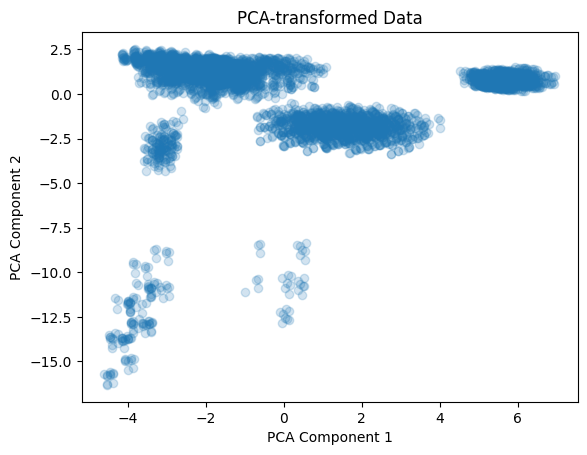

[2024-11-27 23:45:06,836: INFO: 1127899733: Transformed data saved as CSV files.]
[2024-11-27 23:45:06,902: INFO: 1127899733: Transformed data saved as CSV files.]
[2024-11-27 23:45:06,903: INFO: 3533789635: Data transformation pipeline completed successfully and data saved.]


In [7]:
try:
    # Initialize the configuration manager
    config = ConfigurationManager()
    
    # Retrieve the data transformation configuration
    data_transformation_config = config.get_data_transformation_config()
    
    # Create an instance of DataTransformation with the configuration
    data_transformation = DataTransformation(config=data_transformation_config)
    
    # Perform the full data transformation process
    train_pca, test_pca, target_train, target_test = data_transformation.transform()
    
    # Save transformed data
    data_transformation.save_transformed_data(train_pca, test_pca, target_train, target_test)
    
    logger.info("Data transformation pipeline completed successfully and data saved.")
except Exception as e:
    logger.error("An error occurred during the data transformation process: %s", str(e))
    raise e

